### Imports

In [1]:
import pandas as pd
import numpy as np
import random
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
sns.set_style("whitegrid", {"grid.linestyle": ":"})
# sns.set_style("darkgrid", {"grid.linestyle": ":"})
sns.set_context("paper", rc={"font.size":11.5,"axes.titlesize":13,"axes.labelsize":11.5})   

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

import recmetrics

from sklearn.metrics import mean_absolute_error

from surprise import Dataset, get_dataset_dir, Reader, accuracy
from surprise import KNNWithZScore
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate, KFold

import warnings
import itertools
from itertools import chain

np.random.seed(1) # control randomness

## Initially Selected Dataset (ml-latest-small)

We initially chose a custom CSV dataset from Grouplens titled "ml-latest-small", however during implementation, the code did not suit operations we were performing due to its regressional structure i.e., consisted of values between whole rating values.

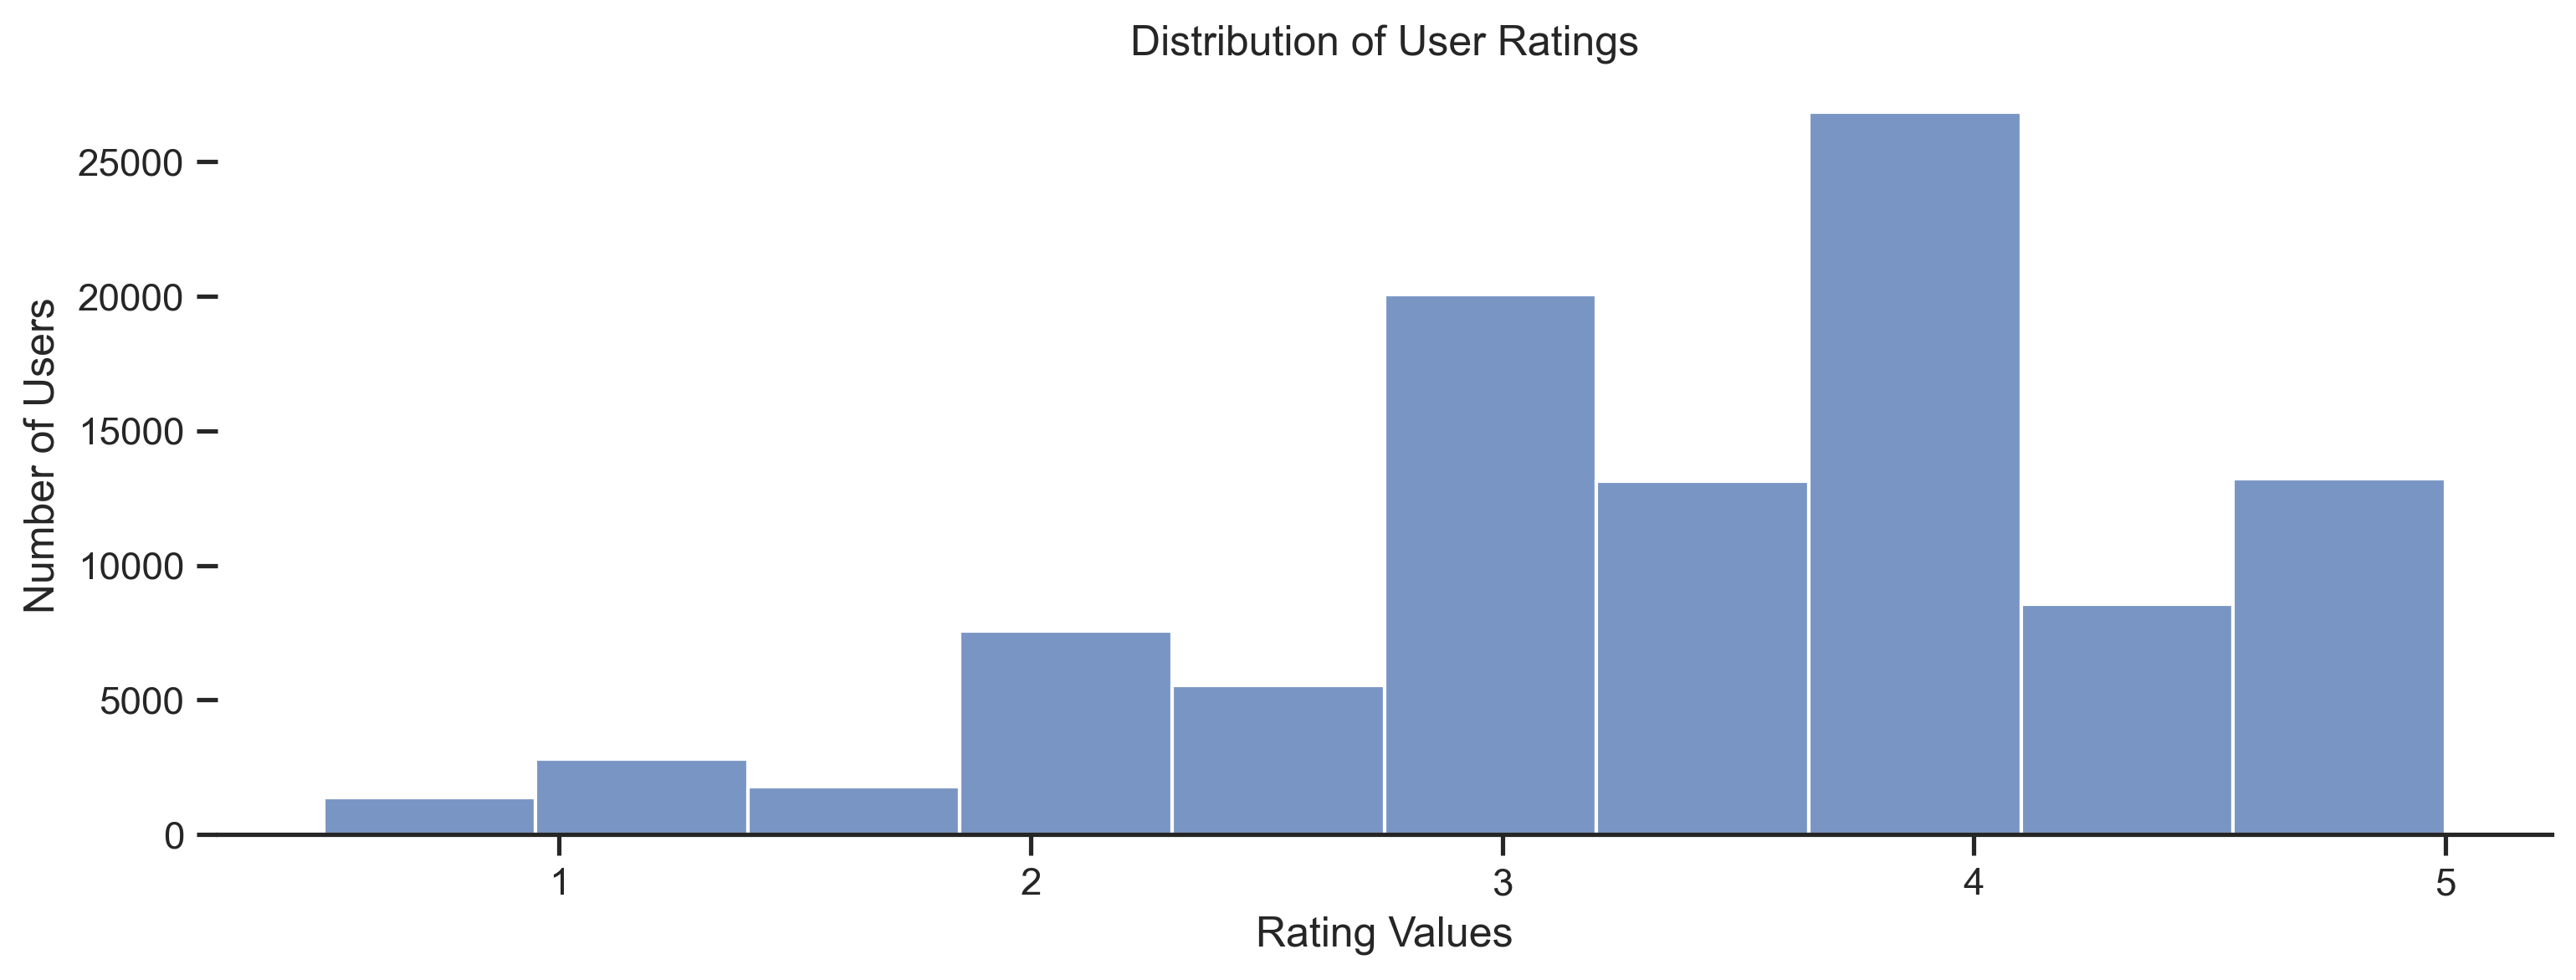

In [2]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')

# plot distribution of user ratings
fig, ax = plt.subplots(figsize=(12,4))

sns.despine(left=True);
sns.histplot(data=ratings['rating'], bins=10);

plt.title('Distribution of User Ratings')
plt.xlabel('Rating Values')
plt.ylabel('Number of Users')
plt.show()

## Custom Dataset Analysis (ml-100k)

Index of datasets: https://files.grouplens.org/datasets/movielens/ml-100k/

In [3]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Per the documentation:
"
The Reader class is used to parse a file containing ratings. Such a file is assumed to specify only one rating per line, and each line needs to respect the following structure: user ; item ; rating ; [timestamp]
"

In [4]:
# dataset converted to surprise object (no timestamp column)
reader = Reader(line_format="user item rating", sep="\t")
data = Dataset.load_from_file("ml-100k/u.data", reader=reader)

In [5]:
# convert object to dataframe
data_df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['userId', 'movieId', 'ratings', 'timestamp'])
data_df = data_df.drop('timestamp', axis=1) # remove empty timestamp column
data_df.head()

,userId,movieId,ratings
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [6]:
# number of users and items
temp = data_df.pivot(index='userId', columns='movieId', values='ratings').shape

print(f'Number of Users: {temp[0]}')
print(f'Number of Items: {temp[1]}')

Number of Users: 943
Number of Items: 1682


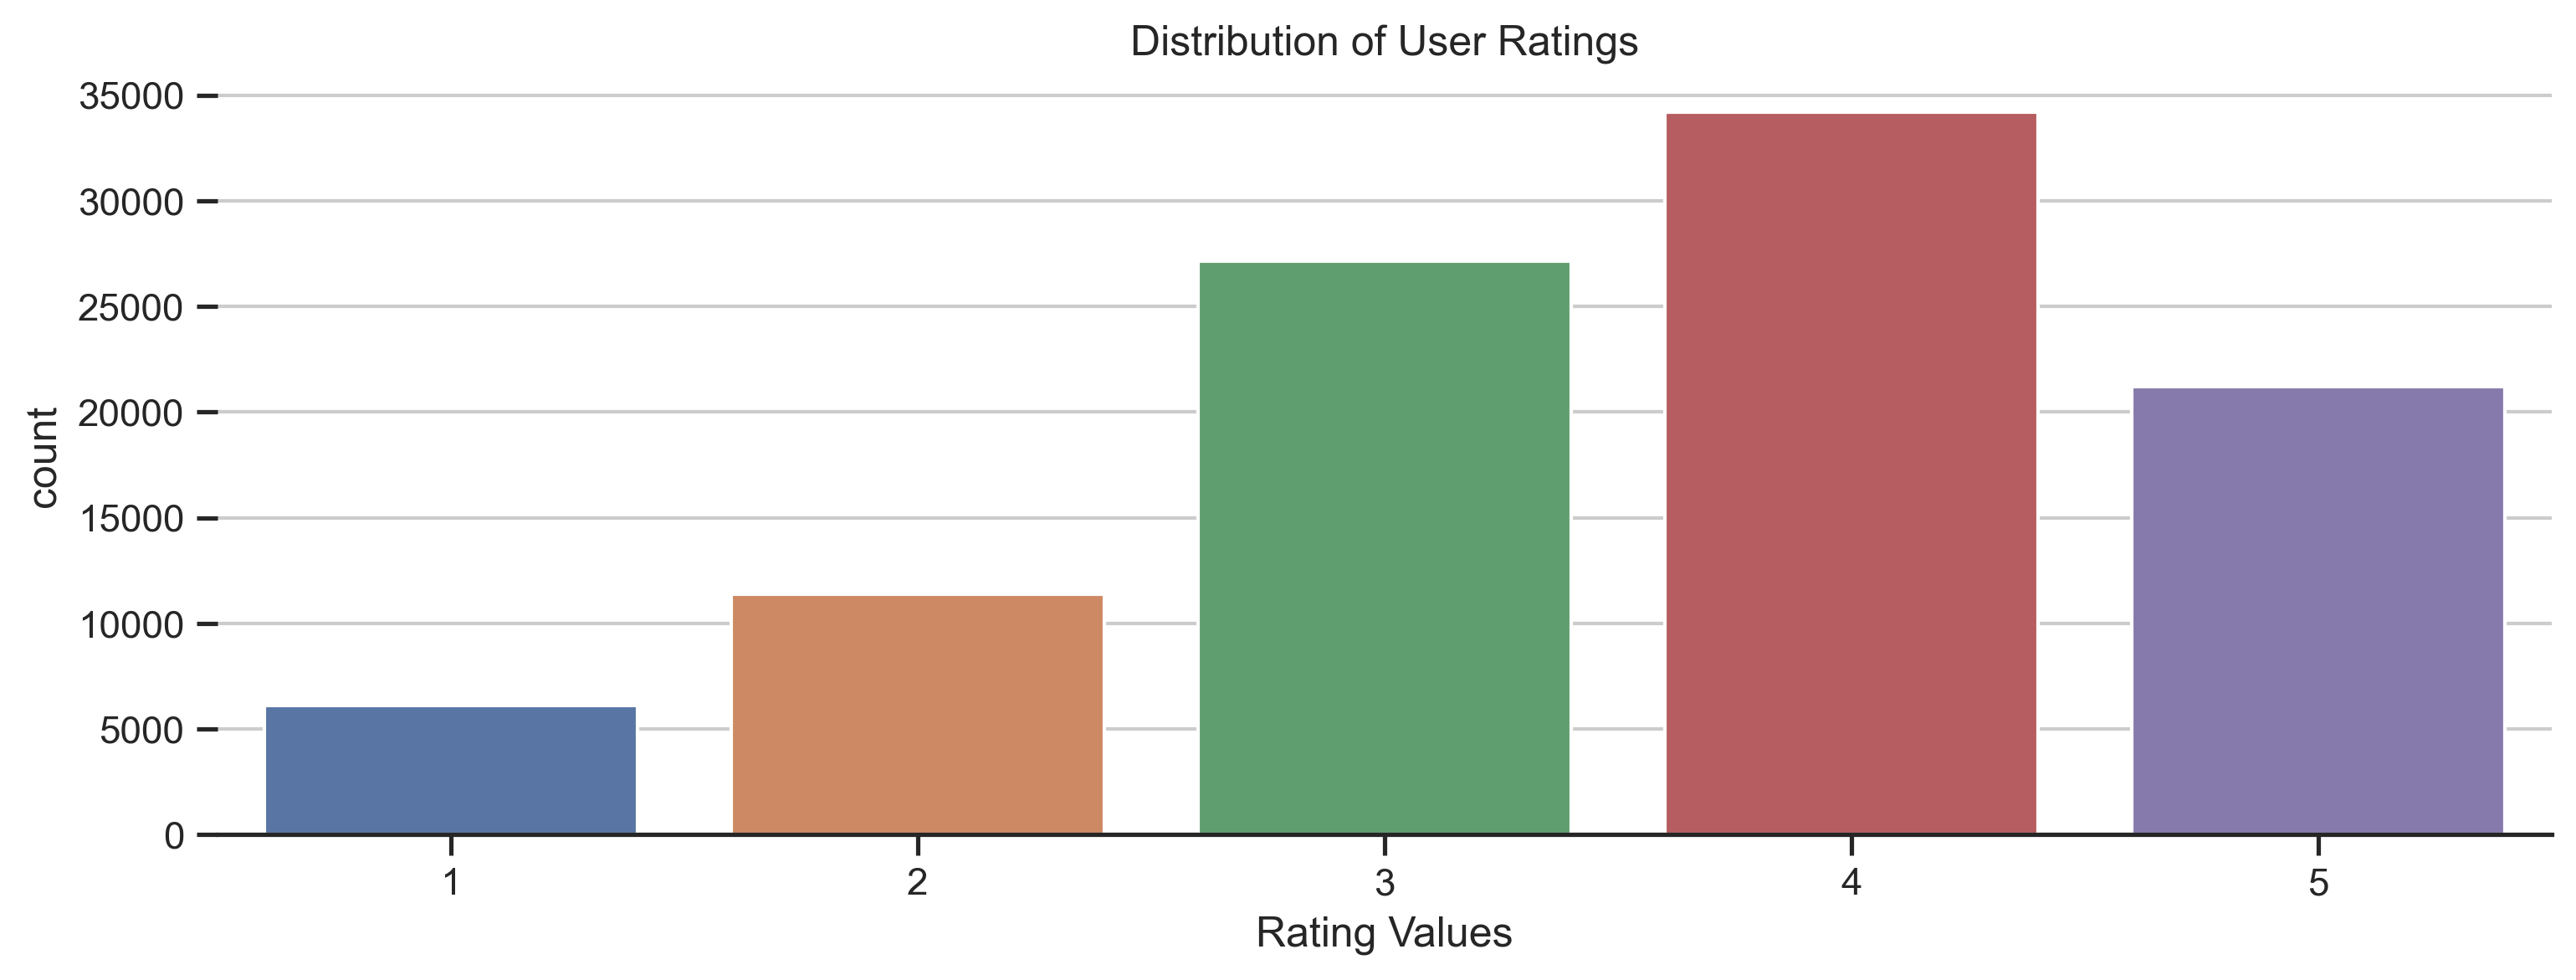

In [7]:
# count of the instances of user ratings
ratings_count = pd.DataFrame(data_df['ratings']).groupby('ratings')['ratings'].count()
ratings_count = ratings_count.to_frame(name='count').reset_index().astype(int)

# plot distribution of user ratings
fig, ax = plt.subplots(figsize=(12,4))

sns.despine(left=True);
sns.barplot(data=ratings_count, x='ratings', y='count');

ax.grid(axis='y')

plt.title('Distribution of User Ratings');
plt.xlabel('Rating Values')
plt.show()

### Long-tail Plot

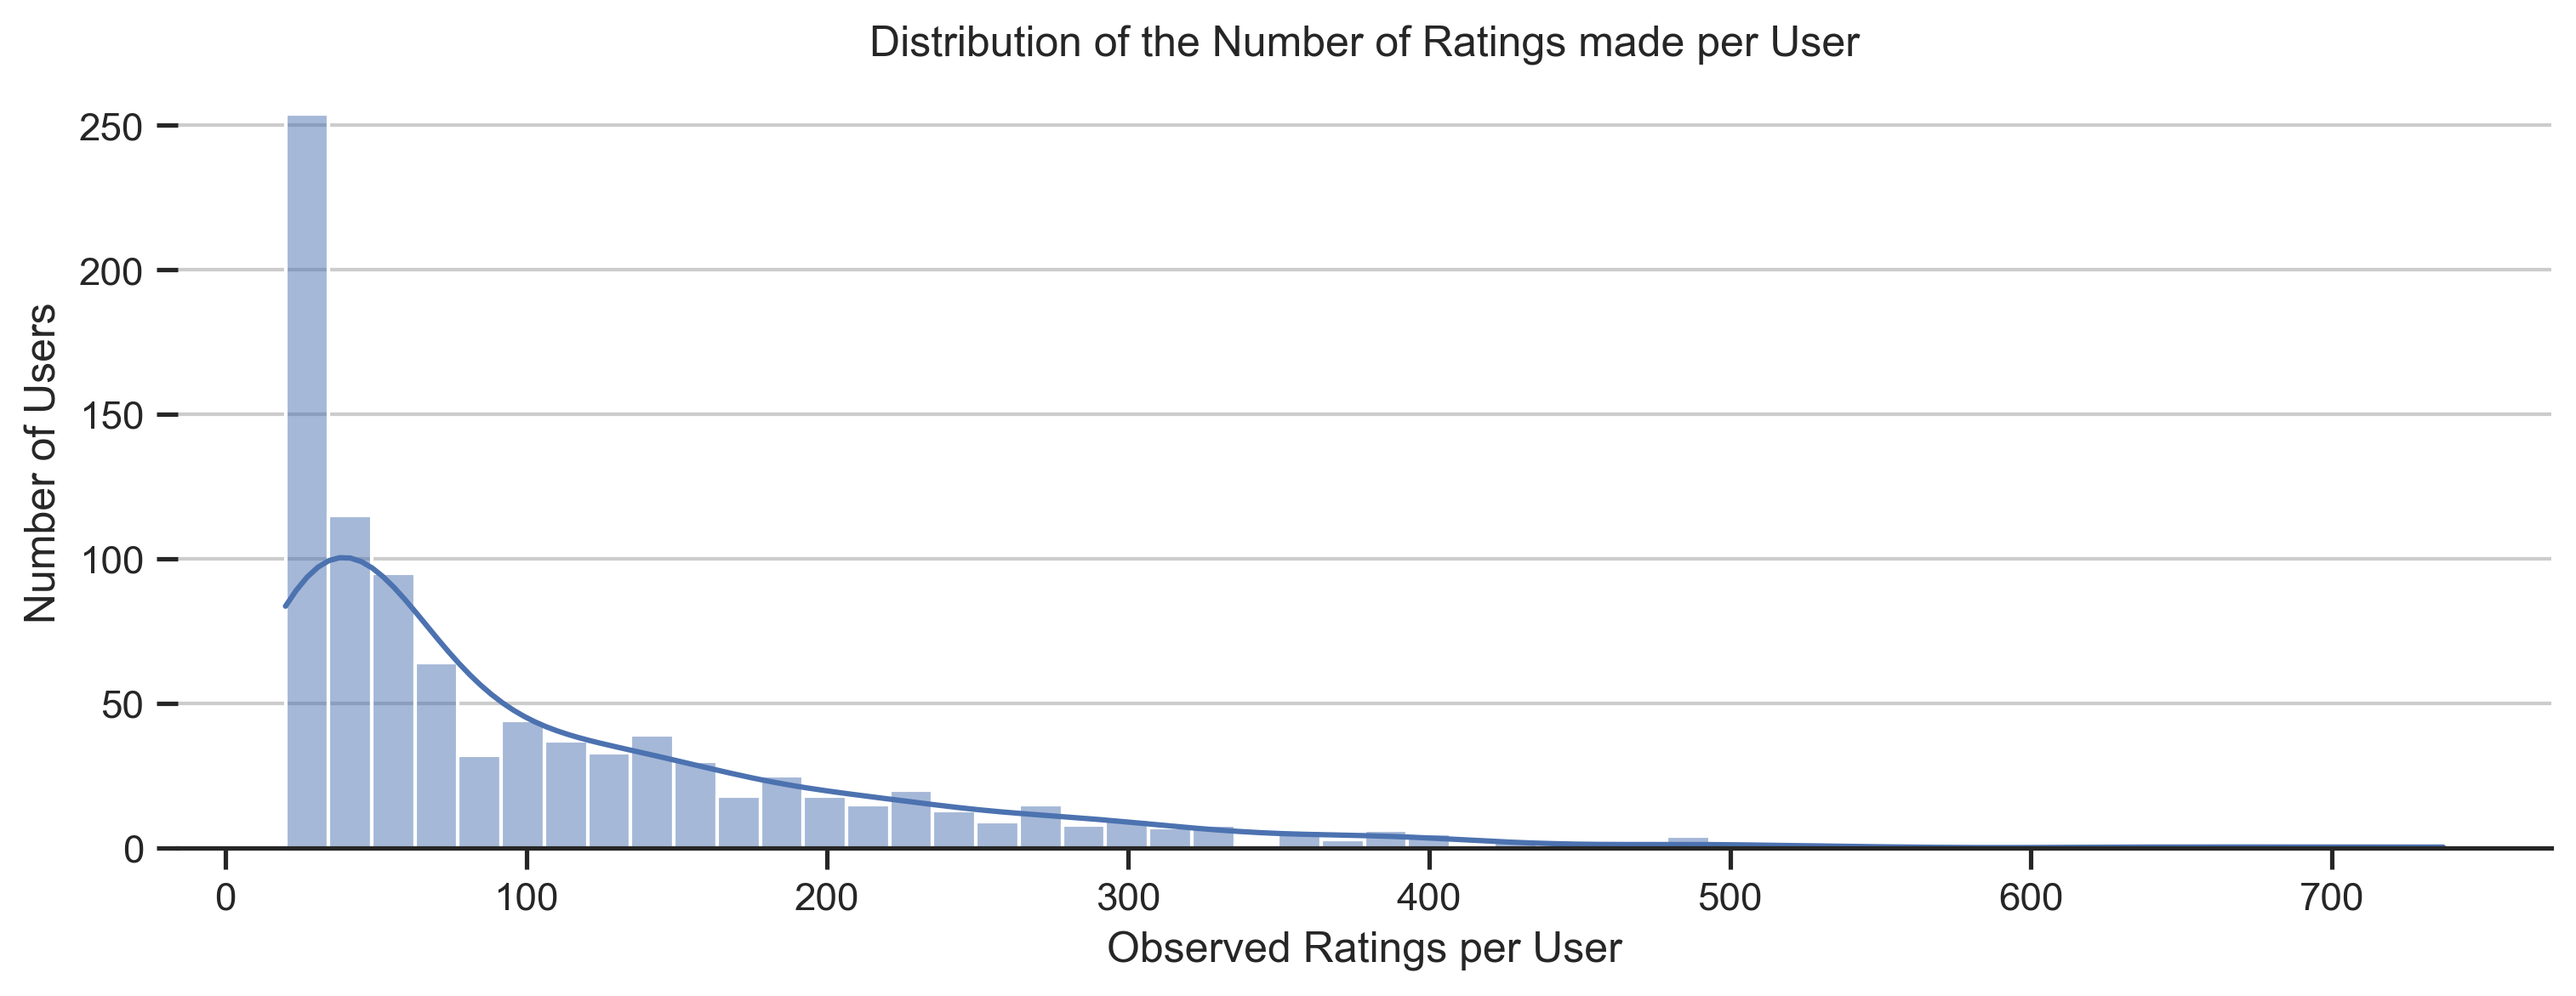

In [8]:
# plot distribution of the number of user ratings
fig, ax = plt.subplots(figsize=(12,4))

sns.despine(left=True);
sns.histplot(data=data_df['userId'].value_counts(), bins=50, kde=True)

ax.grid(axis='y')

plt.title('Distribution of the Number of Ratings made per User')
plt.xlabel('Observed Ratings per User')
plt.ylabel('Number of Users')
plt.show()

In [9]:
data_df['userId'].value_counts().describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: userId, dtype: float64

The previous histogram can be represented with a long tail plot using the recmetrics python library.

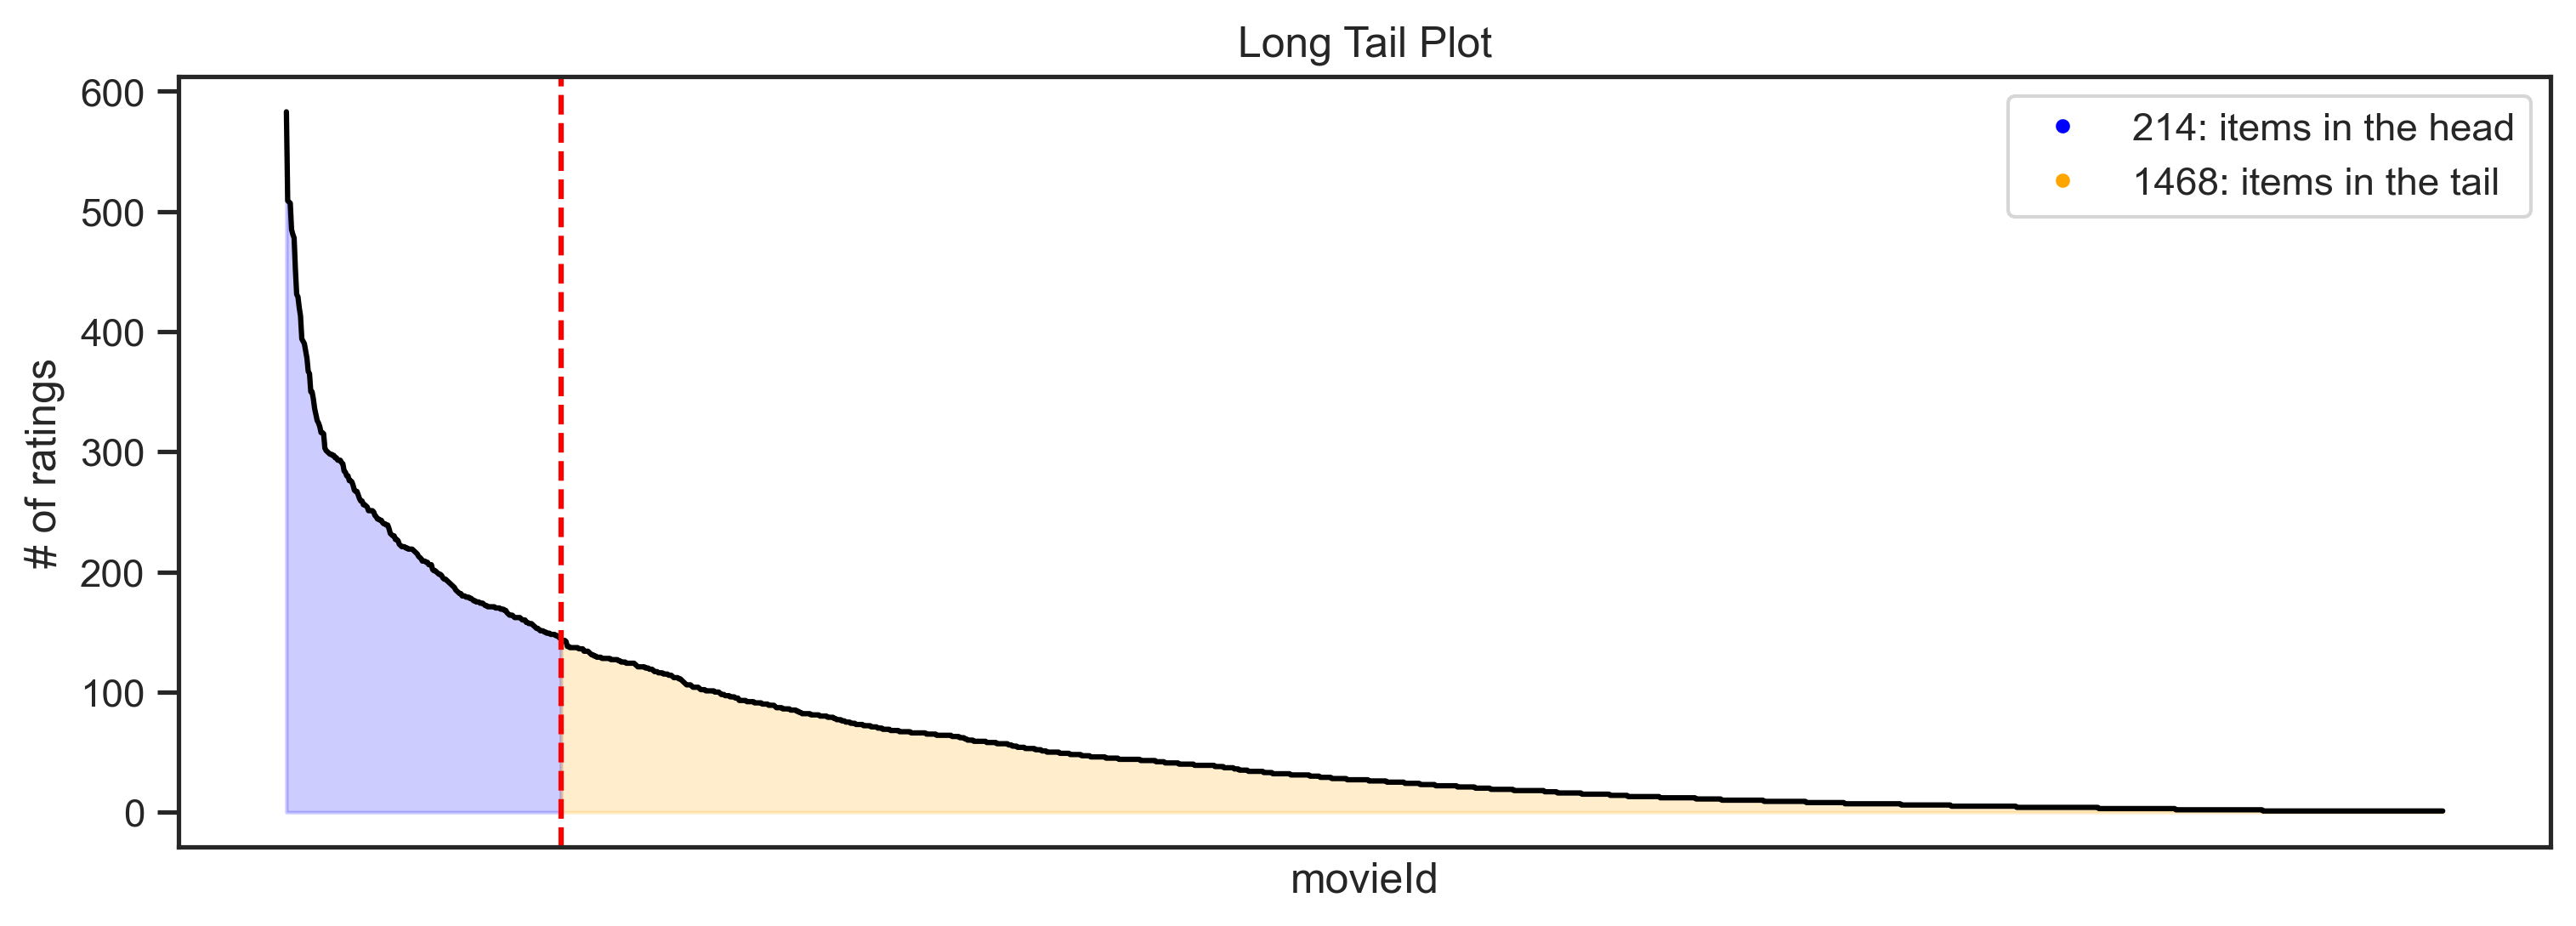

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # ignore warnings message

    figure(figsize=(12,4))

    recmetrics.long_tail_plot(df=data_df, 
                 item_id_column="movieId", 
                 interaction_type="ratings", 
                 percentage=0.5,
                 x_labels=False)

Looking over the user-ratings matrix, we can see the distribution of ratings and the matrices sparsity.

In [11]:
# user-ratings matrix
ratings_matrix = data_df.pivot(index='userId', columns='movieId', values='ratings')

user_ratings_total = ratings_matrix.shape[0] * ratings_matrix.shape[1] - ratings_matrix.isna().sum().sum()
print(f'Number of user ratings: {user_ratings_total}')

missing_ratings_total = ratings_matrix.isna().sum().sum()
print(f'Number of missing ratings: {missing_ratings_total}')

(user_ratings_total / missing_ratings_total) * 100
print(f'Percentage of user ratings: {(user_ratings_total / missing_ratings_total) * 100}')

Number of user ratings: 100000
Number of missing ratings: 1486126
Percentage of user ratings: 6.728904547797428


### Heatmap

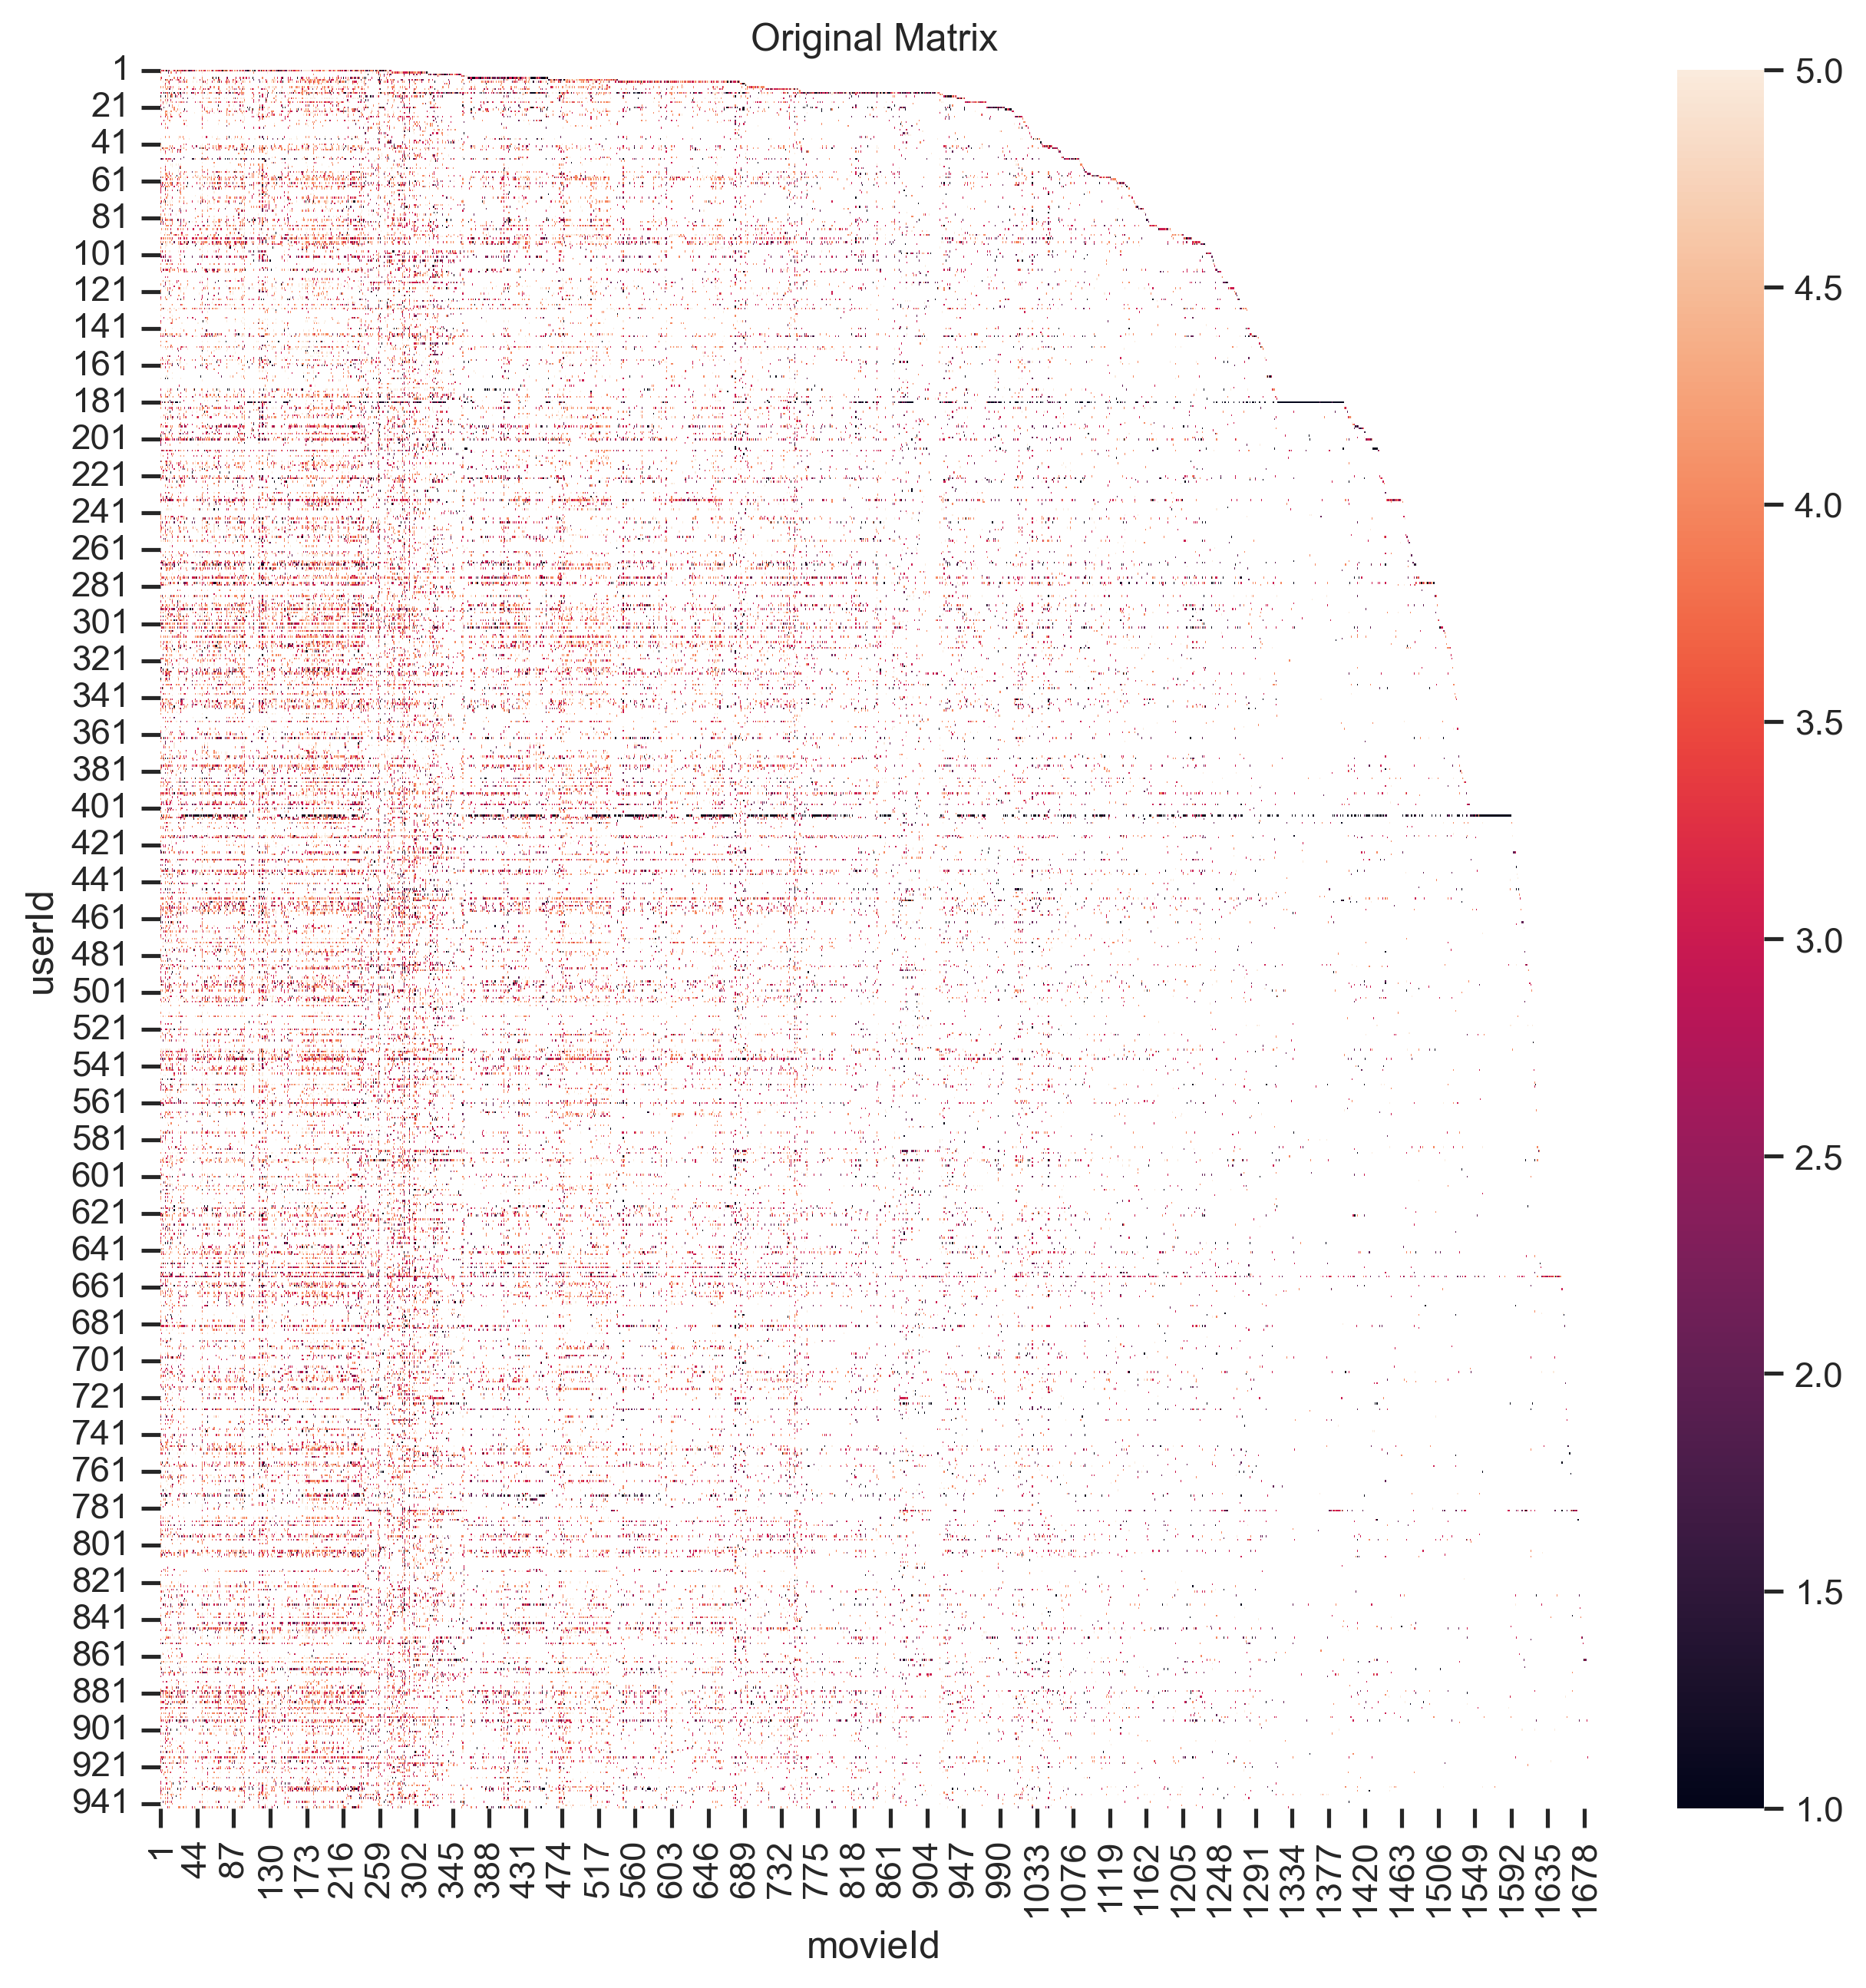

In [12]:
data_df = data_df.astype('int')
data_df = data_df.pivot(index='userId', columns='movieId', values='ratings')

# Reconstruction of original matrix
# Plot matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data_df, ax=ax)
ax.set_title("Original Matrix")
ax.axis('tight')
plt.show()

## Built-in Dataset

Surprise also offers built-in option for our selected dataset which the script below asserts is the exact same (including the timestamp column).

In [13]:
# built-in dataset (includes timestamp column)
built_in_data = Dataset.load_builtin('ml-100k')

built_in_data_df = pd.DataFrame(built_in_data.__dict__['raw_ratings'], columns=['userId', 'movieId', 'rating', 'timestamp'])
built_in_data_df = built_in_data_df.astype('int64')

In [14]:
# ensure both our custom dataset and the built-in dataset are the same
assert(ratings.equals(built_in_data_df))